# Wine Quality Prediction

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from lightgbm import LGBMRegressor


## Data Exploration

In [2]:
## Import data
data = pd.read_csv('../data/WineQT.csv')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [4]:
## Profile of data: 11 numerical features, 1 target variable ("quality")
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043,804.969379
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824,463.997116
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000,0.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,5.000000,411.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000,794.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,6.000000,1209.500000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000,1597.000000


(array([  6.,   0.,  33.,   0., 483.,   0., 462.,   0., 143.,  16.]),
 array([3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. , 7.5, 8. ]),
 <a list of 10 Patch objects>)

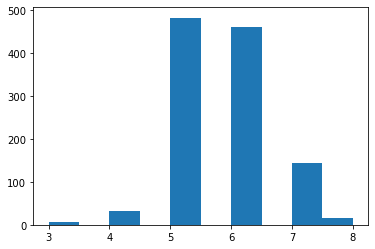

In [5]:
## Let's look at the distribution of the target
target = 'quality'
plt.hist(data[target])

## Data Processing

In [6]:
## Train/test split
X = data.drop([target, 'Id'], axis=1)
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 11), (343, 11), (800,), (343,))

## Model Training

In [7]:
## Set up model & parameter grid
estimator = LGBMRegressor()
params = {
    'n_estimators': [100,1000],
    'max_depth': [2,5],
    'learning_rate': [0.1, 0.01],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.7, 0.8]
}

In [8]:
## Setup grid search cross validation
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid= params,
    scoring = 'neg_mean_squared_error',
    n_jobs = -1,
    cv = StratifiedKFold(n_splits=4),
    #verbose=True
)

In [9]:
## Fit the model
grid_search.fit(X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8],
                         'learning_rate': [0.1, 0.01], 'max_depth': [2, 5],
                         'n_estimators': [100, 1000], 'subsample': [0.8, 0.9]},
             scoring='neg_mean_squared_error')

In [10]:
## Best model parameters
grid_search.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 5,
 'n_estimators': 1000,
 'subsample': 0.8}

In [11]:
## Best model
best_model = grid_search.best_estimator_
best_model

LGBMRegressor(colsample_bytree=0.7, learning_rate=0.01, max_depth=5,
              n_estimators=1000, subsample=0.8)

## Predictions

In [12]:
## Preds
preds = best_model.predict(X_test)
preds.shape

(343,)

In [13]:
## Set up results dataframe to aggregate results
results = pd.DataFrame()
results['actual'] = y_test
results['preds'] = preds
results.reset_index(inplace=True)
results.drop('index', axis=1, inplace=True)
results

,actual,preds
0,5,5.345053
1,6,5.546716
2,5,5.301209
3,6,5.283562
4,6,5.870397
...,...,...
338,5,6.384339
339,6,5.555976
340,6,6.024395
341,5,4.695298


## Performance Metrics

In [14]:
# Performance metrics
mse = mean_squared_error(y_test, preds)
print('MSE: '+str(mse))
mae = mean_absolute_error(y_test, preds)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(y_test, preds))
print('RMSE: '+str(rmse))

MSE: 0.36047130103202124
MAE: 0.46759629941062686
RMSE: 0.600392622399727
